## Imports

In [1]:
import torch

import pandas as pd
import numpy as np

from tqdm import tqdm
from sklearn.metrics import accuracy_score

## Load data and split for train/test

In [2]:
combined_df = pd.read_csv("../data/processed/combined_dataset.csv")
combined_df.set_index(["data_id"], inplace=True)

In [3]:
from sklearn.model_selection import train_test_split

combined_data = np.array(
    list(set(zip(combined_df.index.get_level_values(0), combined_df.label)))
)
data_ids = combined_data[:, 0]
labels = combined_data[:, 1]
train_data_ids, test_data_ids, _, _ = train_test_split(
    data_ids, labels, test_size=0.2, random_state=31, stratify=labels
)

In [4]:
train_x = []
train_y = []
for current_idx, train_data_id in enumerate(train_data_ids):
    current_point = combined_df.loc[train_data_id]
    train_x.append(
        torch.Tensor(
            current_point[["x", "y", "z"]].to_numpy().transpose(1, 0).flatten()
        )
    )
    train_y.append(
        torch.Tensor([1.0] if current_point["label"].unique()[0] == 1 else [0.0])
    )

train_x = torch.vstack(train_x)
train_y = torch.squeeze(torch.vstack(train_y))

In [5]:
train_x.shape, train_y.shape

(torch.Size([155, 225]), torch.Size([155]))

In [6]:
test_x = []
test_y = []
for current_idx, test_data_id in enumerate(test_data_ids):
    current_point = combined_df.loc[test_data_id]
    test_x.append(
        torch.Tensor(
            current_point[["x", "y", "z"]].to_numpy().transpose(1, 0).flatten()
        )
    )
    test_y.append(
        torch.Tensor([1.0] if current_point["label"].unique()[0] == 1 else [0.0])
    )

test_x = torch.vstack(test_x)
test_y = torch.squeeze(torch.vstack(test_y))

In [7]:
test_x.shape, test_y.shape

(torch.Size([39, 225]), torch.Size([39]))

## Model Definition

In [8]:
class ClassificationNetCNN(torch.nn.Module):
    def __init__(self, input_size=225, hidden_size=50, output_size=2):
        super(ClassificationNetCNN, self).__init__()
        self.conv1 = torch.nn.Conv1d(1, 20, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv1d(20, 10, kernel_size=3, padding=1)
        self.linear = torch.nn.Linear(1120, 2)

    def forward(self, x):
        # 1 * 225 -> 20 * 225
        y = self.conv1(x)
        y = torch.relu(y)
        # 20 * 225 -> 20 * 112
        y = torch.max_pool1d(y, 2)

        # 20 * 112 -> 10 * 112
        y = self.conv2(y)
        y = torch.relu(y)

        y = y.view(-1, 1120)

        # n * 1120 -> n * 2
        scores = self.linear(y)
        return scores

In [9]:
model = ClassificationNetCNN()

## Training

In [10]:
lr = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [11]:
def get_accuracy(scores, labels):
    num_data = scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = predicted_labels == labels
    num_matches = indicator.sum()
    return 100 * num_matches.float() / num_data

In [12]:
iterations = 80

train_losses = []
train_accuracies = []
test_accuracies = []

for curr_iter in tqdm(range(iterations), desc="Training Progress"):
    optimizer.zero_grad()
    model_in = train_x
    model_in.requires_grad_()
    model_in = model_in.view(-1, 1, 225)
    model_out = model(model_in)
    loss = criterion(model_out, train_y.long())
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    train_accuracies.append(get_accuracy(model_out, train_y))

    if curr_iter % 10 == 0:
        with torch.no_grad():
            test_x_tr = test_x.view(-1, 1, 225)
            test_out = model(test_x_tr)
            test_accuracies.append(get_accuracy(test_out, test_y))

Training Progress:   0%|                                                                                                                                                           | 0/80 [00:00<?, ?it/s]/var/folders/k7/scjvrz5d2pz78lkds9g31f7m0000gn/T/ipykernel_9504/387962146.py:14: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-accccgfm/c10/core/TensorImpl.h:1156.)
  y = torch.max_pool1d(y, 2)
Training Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 93.08it/s]


## Training Results

<AxesSubplot:>

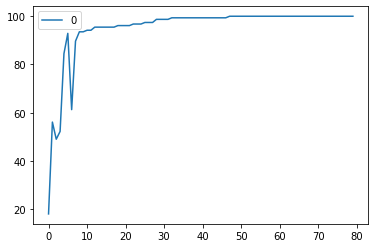

In [13]:
pd.DataFrame(train_accuracies).plot()

<AxesSubplot:>

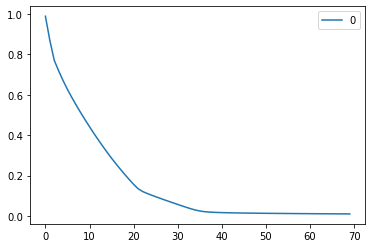

In [14]:
pd.DataFrame(train_losses[10:]).plot()

<AxesSubplot:>

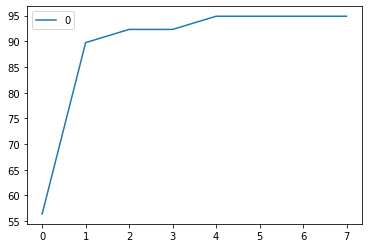

In [15]:
pd.DataFrame(test_accuracies).plot()

In [16]:
get_accuracy(test_out, test_y)

tensor(94.8718)

## Persist Model parameters

In [18]:
# torch.save(model.state_dict(), "../data/checkpoints/cnn.pth")

## Evaluation

In [30]:
from sklearn.metrics import accuracy_score, f1_score, recall_score

from sklearn.metrics import accuracy_score, f1_score, recall_score

def compute_evaluation_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
    }

compute_evaluation_metrics(test_y.numpy(), test_out.argmax(dim=1).numpy())

{'accuracy': 0.9487179487179487, 'f1': 0.9523809523809523, 'recall': 1.0}